In [12]:
import snap
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
import pickle
import Queue

def loadDirectedSigns(filename):
    """
    :param - filename: undirected graph with associated edge sign
    return type: dictionary (key = node pair (a,b), value = sign)
    return: Return sign associated with node pairs. Both pairs, (a,b) and (b,a)
    are stored as keys. Self-edges are NOT included.
    """
    signs = {}
    with open(filename, 'r') as ipfile:
        for line in ipfile:
            if line[0] != '#':
                if filename[-3:] == "csv":
                    line_arr = line.split(',')
                else:
                    line_arr = line.split()
                if line_arr[0] == line_arr[1]:
                    continue
                node1 = int(line_arr[0])
                node2 = int(line_arr[1])
                sign = int(line_arr[2])
                signs[(node1, node2)] = sign

    return signs


def GetNetworkxG(G, signs):
    Gnx = nx.DiGraph()
    Gnxu = nx.Graph()
    for N in G.Nodes():
        Gnx.add_node(N.GetId())
        Gnxu.add_node(N.GetId())
    for E in G.Edges():
        src = E.GetSrcNId()
        dst = E.GetDstNId()
        Gnx.add_weighted_edges_from([(src, dst, signs[(src, dst)])])
        Gnxu.add_weighted_edges_from([(src, dst, signs[(src, dst)])])

    return Gnx, Gnxu


def makeSignsPositive(signs):
    minSign = min(signs.values())
    modMinSign = abs(minSign)
    newSigns = {}
    for i in signs.keys():
        newSigns[i] = signs[i] + modMinSign + 1
    return newSigns


def GetCNCoeff(G, signs, x, y):
    # signs > 0
    # x -> y

    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)

    # wxy
    woo = sum([xo[i] if i in yo.keys() else 0 for i in xo.keys()])
    wio = sum([xi[i] if i in yo.keys() else 0 for i in xi.keys()])
    woi = sum([xo[i] if i in yi.keys() else 0 for i in xo.keys()])
    wii = sum([xi[i] if i in yi.keys() else 0 for i in xi.keys()])

    return woo, wio, woi, wii


def GetJaccardCoeff(G, signs, x, y):
    # signs > 0
    # x -> y

    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)

    # nxy
    noo = sum([xo[i] if i in yo.keys() else 0 for i in xo.keys()])
    nio = sum([xi[i] if i in yo.keys() else 0 for i in xi.keys()])
    noi = sum([xo[i] if i in yi.keys() else 0 for i in xo.keys()])
    nii = sum([xi[i] if i in yi.keys() else 0 for i in xi.keys()])

    # dxy
    doo = sum(xo.values()) + sum(yo.values())
    dio = sum(xi.values()) + sum(yo.values())
    doi = sum(xo.values()) + sum(yi.values())
    dii = sum(xi.values()) + sum(yi.values())

    foo = 1.0 * noo / doo if doo != 0 else 0
    fio = 1.0 * nio / dio if dio != 0 else 0
    foi = 1.0 * noi / doi if doi != 0 else 0
    fii = 1.0 * nii / dii if dii != 0 else 0

    return foo, fio, foi, fii


def PACoeff(G, signs, x, y):
    # signs > 0
    # x -> y

    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)

    woo = sum(xo.values()) * sum(yo.values())
    wio = sum(xi.values()) * sum(yo.values())
    woi = sum(xo.values()) * sum(yi.values())
    wii = sum(xi.values()) * sum(yi.values())

    return woo, wio, woi, wii


def AACoeff(G, signs, x, y, VolO, VolI, Vol):
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)

    woo = sum([1.0 * (xo[z] + yo[z]) / math.log(1 + VolI[z]) if z in yo.keys() else 0 for z in xo.keys()])
    wio = sum([1.0 * (xi[z] + yo[z]) / math.log(1 + Vol[z]) if z in yo.keys() else 0 for z in xi.keys()])
    woi = sum([1.0 * (xo[z] + yi[z]) / math.log(1 + Vol[z]) if z in yi.keys() else 0 for z in xo.keys()])
    wii = sum([1.0 * (xi[z] + yi[z]) / math.log(1 + VolO[z]) if z in yi.keys() else 0 for z in xi.keys()])

    return woo, wio, woi, wii


def RACoeff(G, signs, x, y, VolO, VolI, Vol):
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)

    woo = sum([1.0 * (xo[z] + yo[z]) / VolI[z] if z in yo.keys() else 0 for z in xo.keys()])
    wio = sum([1.0 * (xi[z] + yo[z]) / Vol[z] if z in yo.keys() else 0 for z in xi.keys()])
    woi = sum([1.0 * (xo[z] + yi[z]) / Vol[z] if z in yi.keys() else 0 for z in xo.keys()])
    wii = sum([1.0 * (xi[z] + yi[z]) / VolO[z] if z in yi.keys() else 0 for z in xi.keys()])

    return woo, wio, woi, wii


def CCCoeff(G, signs, x, y, C):
    return C[x] + C[y]


def GetNeighO(G, signs, NId):
    N = G.GetNI(NId)
    Neighs = {}
    OutDeg = N.GetOutDeg()
    for i in range(OutDeg):
        Neigh = N.GetOutNId(i)
        Weight = signs[(N.GetId(), Neigh)]
        Neighs[Neigh] = Weight
    return Neighs


def GetNeighI(G, signs, NId):
    N = G.GetNI(NId)
    Neighs = {}
    InDeg = N.GetInDeg()
    for i in range(InDeg):
        Neigh = N.GetInNId(i)
        Weight = signs[(Neigh, N.GetId())]
        Neighs[Neigh] = Weight
    return Neighs


def GetVolO(G, signs, NId):
    return sum(GetNeighO(G, signs, NId).values())


def GetVolI(G, signs, NId):
    return sum(GetNeighI(G, signs, NId).values())


def GetVol(G, signs, NId):
    return GetVolO(G, signs, NId) + GetVolI(G, signs, NId)

def GetEdgeFeatures(G, pSigns, src, dst, VolO, VolI, Vol, CC):
    	f = []

	c1, c2, c3, c4 = GetCNCoeff(G, pSigns, src, dst)
	f.append(c1)
	f.append(c2)
	f.append(c3)
	f.append(c4)

	c1, c2, c3, c4 = GetJaccardCoeff(G, pSigns, src, dst)
	f.append(c1)
	f.append(c2)
	f.append(c3)
	f.append(c4)

	c1, c2, c3, c4 = PACoeff(G, pSigns, src, dst)
	f.append(c1)
	f.append(c2)
	f.append(c3)
	f.append(c4)

	c1, c2, c3, c4 = AACoeff(G, pSigns, src, dst, VolO, VolI, Vol)
	f.append(c1)
	f.append(c2)
	f.append(c3)
	f.append(c4)

	c1, c2, c3, c4 = RACoeff(G, pSigns, src, dst, VolO, VolI, Vol)
	f.append(c1)
	f.append(c2)
	f.append(c3)
	f.append(c4)

	c1 = CCCoeff(G, pSigns, src, dst, CC)
	f.append(c1)

	f.append(1)
	return f

def GetVectors(G, signs):
    pSigns = makeSignsPositive(signs)
    Gnx, Gnxu = GetNetworkxG(G, pSigns)

    Vol = {}
    VolI = {}
    VolO = {}
    CC = {}
    for N in G.Nodes():
        CC[N.GetId()] = nx.clustering(Gnxu, N.GetId())
        VolO[N.GetId()] = GetVolO(G, pSigns, N.GetId())
        VolI[N.GetId()] = GetVolI(G, pSigns, N.GetId())
        Vol[N.GetId()] = GetVol(G, pSigns, N.GetId())

    M = []
    Y = []
    for e in G.Edges():
        src = e.GetSrcNId()
        dst = e.GetDstNId()
	f = GetEdgeFeatures(G, pSigns, src, dst, VolO, VolI, Vol, CC)

        M.append(f)
        Y.append(pSigns[src, dst])

    return np.array(M), np.array(Y)


def RestrictGraph(G, x, y):
    depths = {}
    Q = Queue.Queue()
    Q.put(x)
    Q.put(y)
    depths[x] = 0
    depths[y] = 0

    while not Q.empty():
        NId = Q.get()
        N = G.GetNI(NId)
        Deg = N.GetDeg()
        for i in range(Deg):
            Neigh = N.GetNbrNId(i)
            if Neigh not in depths.keys():
                Q.put(Neigh)
                depths[Neigh] = depths[NId] + 1

    MaxDepth = 2
    Gr = snap.TNGraph.New()
    for N in G.Nodes():
        if (N.GetId() in depths.keys()) and (depths[N.GetId()] <= MaxDepth):
            Gr.AddNode(N.GetId())
    for E in G.Edges():
        if Gr.IsNode(E.GetSrcNId()) and Gr.IsNode(E.GetDstNId()):
            Gr.AddEdge(E.GetSrcNId(), E.GetDstNId())

    return Gr

def GetRestrictedSigns(Gr, signs):
    rSigns = {}
    for (x, y) in signs.keys():
        if Gr.IsEdge(x, y):
            rSigns[(x, y)] = signs[(x, y)]
    return rSigns

def saveCoefficients(c, filename):
	with open(filename, 'w') as f:
		pickle.dump(c, f)
	f.close()
	print "done writing"

def readCoefficients(filename):
	Coeffs = None
	with open(filename) as f:
		Coeffs = pickle.load(f)
	f.close()
	print "done reading"
	return Coeffs

G = snap.LoadEdgeList(snap.PNGraph, "Datasets/soc-sign-bitcoinotc.csv", 0, 1, ',')
signs = loadDirectedSigns("Datasets/soc-sign-bitcoinotc.csv")
#M, Y = GetVectors(G, signs)
#print "Done making feature vectors:", M.shape, Y.shape
#coefficients = np.linalg.lstsq(M, Y)
#saveCoefficients(coefficients, 'coeff.pkl')
coefficients = readCoefficients('coeff.pkl')
print coefficients[0].shape

### Testing
pSigns = makeSignsPositive(signs)
# Gnx, Gnxu = GetNetworkxG(G, pSigns)
# c = 0
# Vol = {}
# VolI = {}
# VolO = {}
# CC = {}
# for N in G.Nodes():
# 	CC[N.GetId()] = nx.clustering(Gnxu, N.GetId())
# 	VolO[N.GetId()] = GetVolO(G, pSigns, N.GetId())
# 	VolI[N.GetId()] = GetVolI(G, pSigns, N.GetId())
# 	Vol[N.GetId()] = GetVol(G, pSigns, N.GetId())
# X = []
# Y = []
# for e in G.Edges():
# 	src = e.GetSrcNId()
#         dst = e.GetDstNId()
# 	f = GetEdgeFeatures(G, pSigns, src, dst, VolO, VolI, Vol, CC)
# 	predicted = np.dot(coefficients[0], f)
# 	actual = pSigns[(src, dst)]
# 	X.append(actual)
# 	Y.append(predicted)

# ConfusionX = [0 for i in range(30)]
# Confusion = [ConfusionX for i in range(30)]
# npConfusion = np.array(Confusion)

# for i in range(len(X)):
# 	npConfusion[X[i]][int(Y[i])] += 1
# saveCoefficients(npConfusion, 'confusion.pkl')
npConfusion = readCoefficients("confusion.pkl")

# plt.plot(X, Y)
# plt.show()

done reading
(22,)
done reading


5881 35592
done reading


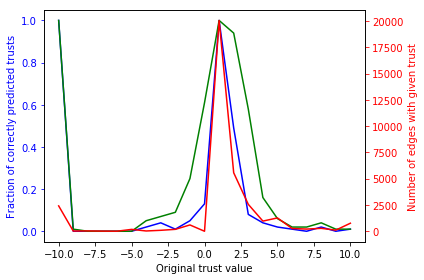

0.716655147224


In [57]:
print G.GetNodes(), G.GetEdges()
confusion = readCoefficients("confusion.pkl")
# print [sum(c) for c in confusion]

a = [0 for i in range(30)]
for i in pSigns.keys():
    a[pSigns[i]] += 1
# print a

percent = []
percent2 = []
for i in range(len(confusion)):
    mini = max(0, i - 1)
    maxi = min(i + 1, 30)
    correct2 = sum(confusion[i][mini:maxi+1])
    correct = confusion[i][i]
    if correct2 < correct:
        print "ohh!", mini, maxi, i, correct, correct2
        print confusion[i]
    actual = sum(confusion[i])
    percent.append(round(1.0 * correct / actual if actual > 0 else 1.0, 2))
    percent2.append(round(1.0 * correct2 / actual if actual > 0 else 1.0, 2))

X = [i - 10 for i in range(len(percent))[:21]]
Y2 = a[1:22] #[:21]
Y1 = percent[:21]
Y15 = percent2[:21]
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(X, Y1, 'b-')
ax1.plot(X, Y15, 'g-')
ax1.set_xlabel('Original trust value')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Fraction of correctly predicted trusts', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(X, Y2, 'r-')
ax2.set_ylabel('Number of edges with given trust', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

print 1.0 * sum([Y1[i] * Y2[i] for i in range(len(Y1))]) / sum(Y2)

# plt.plot([i - 10 for i in range(len(percent))[:21]], percent[:21], color = 'r', label = "Fraction of correct classification")
# plt.plot([i - 10 for i in range(len(percent))[:21]], a[:21], color = 'b', label = "fad")
# plt.xlabel('Original trust')
# plt.ylabel('Fraction of correct trust prediction')
# plt.title('Correct trust prediction')
# plt.show()


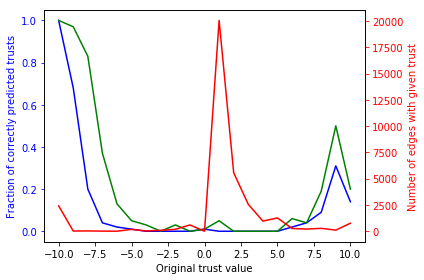

0.0734541469993


In [59]:
coefficients = readCoefficients("coeff.pkl")
print max(signs.values()), len(signs.keys())
print coefficients[1] / 

done reading
10 35592
[ 394948.97243049]
